In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=1.5)
from tqdm import tqdm

In [2]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])
I = np.eye(2)

def Hamiltonian(lmb):    
    Hx = 2.0 
    Hz = 3.0
    H0Energiesnoninteracting = [0.0, 2.5, 6.5, 7.0]
    
    HI = Hz*np.kron(sigma_z, sigma_z) + Hx*np.kron(sigma_x, sigma_x)
    H0 = np.diag(H0Energiesnoninteracting)
    H = H0 + lmb*HI
    return H


def trace_out(state, index):
    density = np.outer(state, np.conj(state))
    if index == 0:
        op0 = np.kron(ket0, I)
        op1 = np.kron(ket1, I)
    elif index == 1:
        op0 = np.kron(I, ket0)
        op1 = np.kron(I, ket1)
    return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T # need to take conj() on first and .T on second since np.arrays are 

In [3]:
lmbvalues_ana = np.arange(0, 1, 0.01)
eigvals_ana = np.zeros((len(lmbvalues_ana), 4))
entropy = np.zeros((len(lmbvalues_ana), 4))
for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]
    for i in range(4):
        sub_density = trace_out(eigvecs[:, i], 0) # trace out qubit 0 from the ground state
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed() # remove zeros to avoid log(0)
        entropy[index, i] = -np.sum(lmb_density*np.log2(lmb_density))

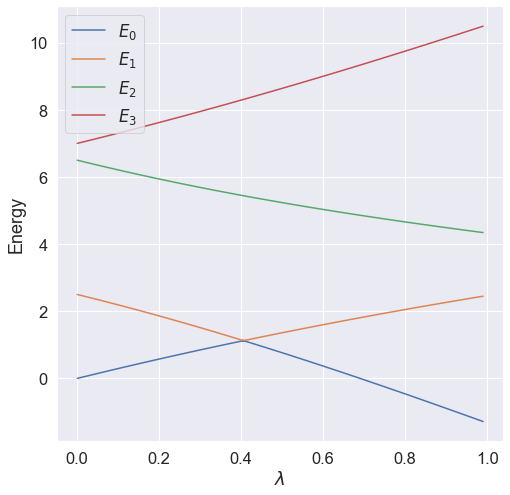

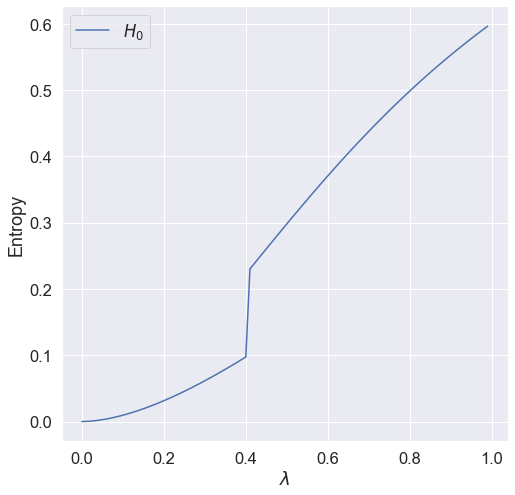

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(4):
    axs.plot(lmbvalues_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(1):
    axs.plot(lmbvalues_ana, entropy[:, i], label=f'$H_{i}$')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Entropy')
axs.legend()
plt.show()


## Rewrite the Hamiltonian in terms of Pauli matrices
The unperturbed Hamiltonian is determined by its eigenvalues and eigenvectors
$$
\begin{align}
    H_0\ket{00} 
    &= 
    \epsilon_{00}\ket{00}
    \\[1ex]
    H_0\ket{01}
    &=
    \epsilon_{01}\ket{01}
    \\[1ex]
    H_0\ket{10}
    &=
    \epsilon_{10}\ket{10}
    \\[1ex]
    H_0\ket{11}
    &=
    \epsilon_{11}\ket{11}.
\end{align}
$$
I want to rewrite the Hamiltonian in terms of tensor products of $I$ and $Z$:
$$
    H_0 = A I\otimes I + BI\otimes Z + CZ\otimes I + DZ\otimes Z,
$$
where $A, B, C, D$ are coefficients I need to find. The coefficients are determined by the eigenvalues and eigenvectors of $H_0$. When applying the eigenstates of $H_0$ to the rewritten Hamiltonian, I get the following set of equations:
$$
\begin{align}
    A + B + C + D &= \epsilon_{00}
    \\[1ex]
    A - B + C - D &= \epsilon_{01}
    \\[1ex]
    A + B - C - D &= \epsilon_{10}
    \\[1ex]
    A - B - C + D &= \epsilon_{11}.
\end{align}
$$
The solutions to these equations are given by 
$$
\begin{align}
    \begin{pmatrix}
        A \\ B \\ C \\ D
    \end{pmatrix}
    &= 
    \frac{1}{4}\begin{pmatrix}
        1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1
    \end{pmatrix}
    \begin{pmatrix}
        \epsilon_{00} \\ \epsilon_{01} \\ \epsilon_{10} \\ \epsilon_{11}
    \end{pmatrix}
    \\[5ex]
    &=
    \frac{1}{4}\begin{pmatrix}
        \epsilon_{00} & \epsilon_{01} & \epsilon_{10} & \epsilon_{11} \\ \epsilon_{00} & -\epsilon_{01} & \epsilon_{10} & -\epsilon_{11} \\ \epsilon_{00} & \epsilon_{01} & -\epsilon_{10} & -\epsilon_{11} \\ \epsilon_{00} & -\epsilon_{01} & -\epsilon_{10} & \epsilon_{11}
    \end{pmatrix}
\end{align}
$$


I want to measure in the computational basis, so I need to rewrite the Hamiltonian in terms of  $Z\otimes I$. This is done by the following operations:
$$
\begin{align}
    I\otimes Z 
    &=
    SWAP(Z\otimes I)SWAP
    \\[1ex]
    Z\otimes Z
    &=
    CX_{1,0}(Z\otimes I)CX_{1,0}
    \\[1ex]
    X\otimes X
    &=
    (H\otimes H)CX_{1,0}(Z\otimes I)CX_{1,0}(H\otimes H).
\end{align}
$$ 

The gate $CX_{1,0}$ is the controlled-not gate with the control qubit being the second qubit and the target qubit being the first qubit, 
i.e 
$$ CX_{1,0}\ket{0,0} = \ket{0,0} \quad \quad CX_{1,0}\ket{0,1} = \ket{1, 1} \quad \quad CX_{1,0}\ket{1,0} = \ket{1, 0} \quad \quad CX_{1,1}\ket{0,1} = \ket{0, 1}. $$


The Hamiltonian can thus be expressed as 
$$
\begin{align}
    H 
    &=
    H_0 + H_I
    \\[1ex]
    &=
    A I\otimes I + B I\otimes Z + C Z\otimes I + D Z\otimes Z + \lambda H_X X\otimes X + \lambda H_Z Z\otimes Z
    \\[1ex]
    &=
    A I\otimes I + B SWAP(Z\otimes I)SWAP + C Z\otimes I 
    \\[1ex]
    \hphantom{some text={}}&+
    \left(D + \lambda H_Z \right) CX_{1,0}(Z\otimes I)CX_{1,0}
    + \lambda H_X (H\otimes H)CX_{1,0}(Z\otimes I)CX_{1,0}(H\otimes H) 
\end{align}
$$


In [5]:
from src.qc import *

def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, lmb, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_cnot10() # rotate measurement basis
    measure_zz = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_zz, measure_xx])
    constants = np.array([B, C, D + lmb*Hz, lmb*Hx])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = A + np.sum(constants * exp_vals) / number_shots
    return exp_val


In [6]:
def minimize_energy(lmb, number_shots, angles_0, learning_rate, max_epochs):
    angles = angles_0 
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, lmb, number_shots)
    while (epoch < max_epochs) and (delta_energy > 1e-5):
        grad = np.zeros_like(angles)
        for idx in range(angles.shape[0]):
            angles_temp = angles.copy()
            angles_temp[idx] += np.pi/2 
            E_plus = get_energy(angles_temp, lmb, number_shots)
            angles_temp[idx] -= np.pi 
            E_minus = get_energy(angles_temp, lmb, number_shots)
            grad[idx] = (E_plus - E_minus)/2
        angles -= learning_rate*grad 
        new_energy = get_energy(angles, lmb, number_shots)
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy

In [7]:
number_shots_search = 1000
learning_rate = 0.3
max_epochs = 5000
lmbvalues = np.linspace(0.0, 1.0, 11)
min_energy = np.zeros(len(lmbvalues))
epochs = np.zeros(len(lmbvalues))
for index, lmb in enumerate((lmbvalues)):
    angles0 = np.random.uniform(low = 0, high = np.pi, size = 4)
    angles, epochs[index], converged, min_energy[index], delta_energy = minimize_energy(lmb, number_shots_search, angles0, learning_rate, max_epochs)
    print(f'Lambda = {lmb}, Energy = {min_energy[index]}, Epochs = {epochs[index]}, Converged = {converged}, Delta Energy = {delta_energy}')

Lambda = 0.0, Energy = 0.0, Epochs = 14.0, Converged = True, Delta Energy = 0.0
Lambda = 0.1, Energy = 0.2918000000000003, Epochs = 666.0, Converged = True, Delta Energy = 0.0
Lambda = 0.2, Energy = 0.5576999999999996, Epochs = 270.0, Converged = True, Delta Energy = 0.0
Lambda = 0.30000000000000004, Energy = 1.1761999999999997, Epochs = 24.0, Converged = True, Delta Energy = 0.0
Lambda = 0.4, Energy = 1.1301000000000005, Epochs = 632.0, Converged = True, Delta Energy = 4.440892098500626e-16
Lambda = 0.5, Energy = 0.7549999999999999, Epochs = 250.0, Converged = True, Delta Energy = 0.0
Lambda = 0.6000000000000001, Energy = 0.41769999999999996, Epochs = 1686.0, Converged = True, Delta Energy = 4.440892098500626e-16
Lambda = 0.7000000000000001, Energy = 0.016699999999999715, Epochs = 1396.0, Converged = True, Delta Energy = 0.0
Lambda = 0.8, Energy = -0.4709000000000003, Epochs = 2647.0, Converged = True, Delta Energy = 0.0
Lambda = 0.9, Energy = -0.8902000000000001, Epochs = 3003.0, Con

In [8]:
from scipy.optimize import minimize
number_shots = 10_000
lmbvalues = np.linspace(0.0, 1.0, 50)
min_energy_scipy = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.44it/s]


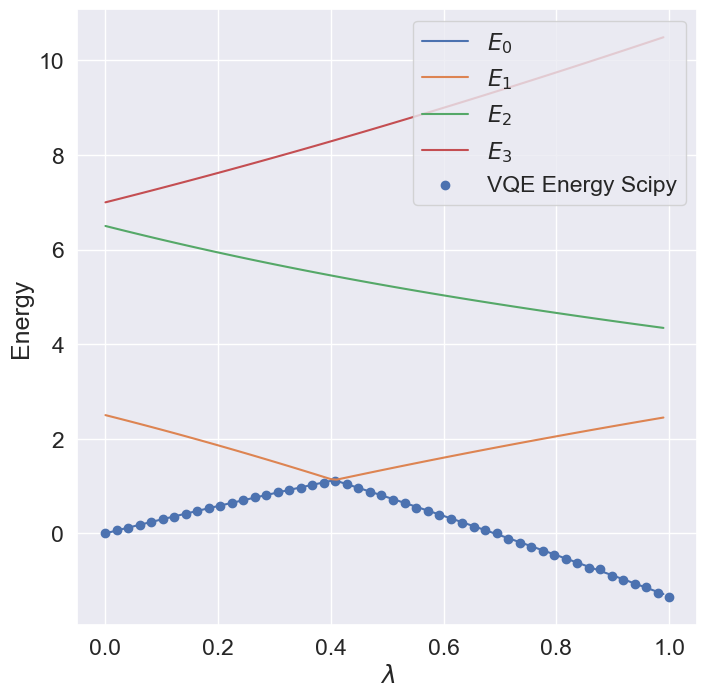

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(4):
    axs.plot(lmbvalues_ana, eigvals_ana[:, i], label=f'$E_{i}$')
axs.set_xlabel(r'$\lambda$')
# axs.scatter(lmbvalues, min_energy, label='VQE Energy GD', marker='o')
axs.scatter(lmbvalues, min_energy_scipy, label='VQE Energy Scipy', marker='o')
axs.set_ylabel('Energy')
axs.legend()
plt.show()